In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import chess
from sarfa import core, OffenseDefenseBoardVisualization, SarfaBaseline, Engine, RemovalPerturber
from utils import get_all_pos
from IPython.display import Image, display
from collections import defaultdict

In [3]:
def offense_defense_saliency_algorithm(fen, action=None) -> tuple[dict[str, tuple[str, float]], chess.Move]:
    board = chess.Board(fen)

    saliency_results: dict[str, tuple[str, float]] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board)
    optimal_move_original_board = action

    for perturbed_board, perturbed_position_str in perturber.process():
        sarfa_compute_result = saliency_calculator.compute(perturbed_board, 
        action, allow_defense=True)
        saliency = sarfa_compute_result.saliency
        dP = sarfa_compute_result.dP
        optimal_move = sarfa_compute_result.optimal_move


        if (optimal_move_original_board == None):
            optimal_move_original_board = chess.Move.from_uci(optimal_move)

        saliency_type = ""
        if dP < 0:
            saliency_type = "defensive"
            saliency = abs(saliency)
        else:
            saliency_type = "offensive"

        saliency_results[perturbed_position_str] = [saliency_type, saliency]

    return saliency_results, optimal_move_original_board


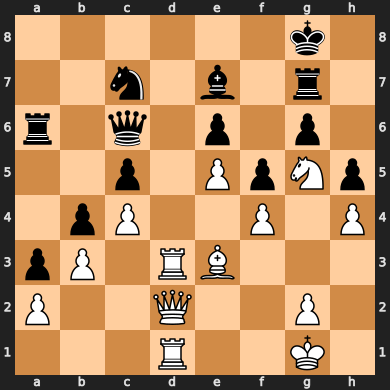

In [4]:
FEN = '6k1/2n1b1r1/r1q1p1p1/2p1PpNp/1pP2P1P/pP1RB3/P2Q2P1/3R2K1 w - - 0 1'
board = chess.Board(FEN)
engine = Engine("./stockfish_15_x64_avx2")
board_visualization = OffenseDefenseBoardVisualization(board)
board_visualization.only_board()

In [5]:
saliency_results, optimal_move_original_board = offense_defense_saliency_algorithm(FEN, action=None)

In [6]:
saliency_results

defaultdict(int,
            {'a2': ['offensive', 0.4117615758302574],
             'a3': ['offensive', 0.5284978467801537],
             'a6': ['offensive', 0.16339676368791964],
             'b3': ['offensive', 0.4145148751544848],
             'b4': ['offensive', 0.40526370718733606],
             'c4': ['offensive', 0.4462553271322627],
             'c5': ['defensive', 1.8675073326887215],
             'c6': ['offensive', 0.0820512744202666],
             'c7': ['offensive', 0.0801273717318865],
             'd1': ['offensive', 0.41561189831286505],
             'd2': ['offensive', 0.41516320036150034],
             'd3': ['offensive', 0.4501818563965414],
             'e3': ['offensive', 0.3783544425355457],
             'e5': ['offensive', 0.41273264455940645],
             'e6': ['offensive', 0.22468869707730782],
             'e7': ['offensive', 0.049586190864150566],
             'f4': ['offensive', 0.3415968449654473],
             'f5': ['defensive', 26.342440797870253],
   

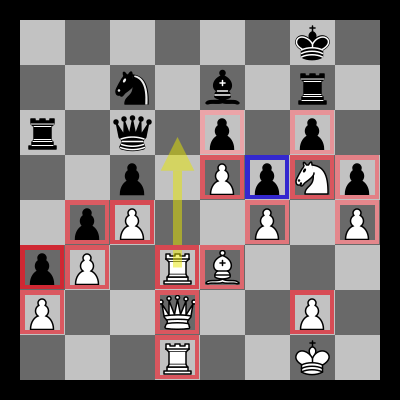

In [7]:
path = board_visualization.show_heatmap(saliency_results, optimal_move_original_board)
display(Image(path))